In [1]:
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import os
import time
import sys
sys.path.append(os.getcwd())
from src.backup.hawkes import dataLoader, inference, simulate, simulate_optimized #not importing fit because some error with tick installation
from src.fit import ConditionalLeastSquaresLogLin

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
np.random.seed(1)

# Generate Fake Data

## Create Fake Params

In [6]:
if not os.path.isdir('tmp') : os.mkdir('tmp')

### Make Norms Matrix

In [7]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .5
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))
# print(mat)

In [8]:
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

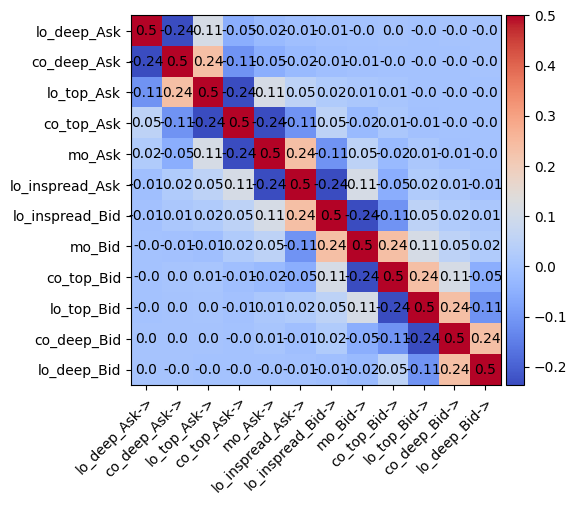

In [9]:

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
# plt.show()


In [10]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

np.complex128(0.9452125130879911+0j)

### Make fake TOD params

In [11]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0
with open("tmp//fakeData_Params_sod_eod_dictTOD_constt", "wb") as f:
    pickle.dump(faketod, f)

### Make Fake Power Law Kernel Params

In [12]:
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

In [13]:
mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])

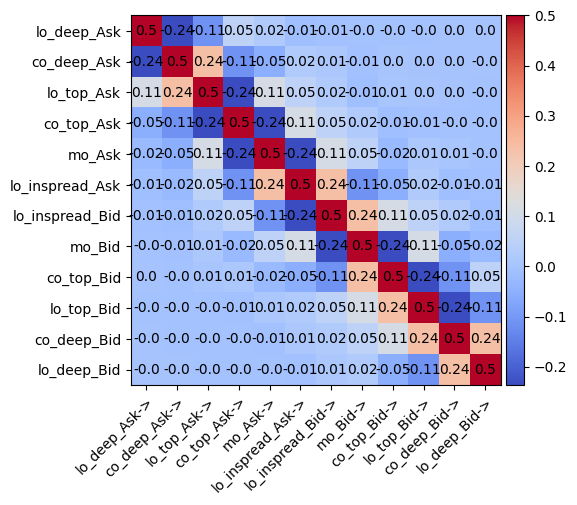

In [14]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
fig.savefig("tmp//heatmap.png")
plt.show()



In [15]:
# # norm should be less than 1
np.max(np.linalg.eig(mat)[0])

np.complex128(0.9452125130879943+0j)

In [16]:
with open("tmp//fake_ParamsInferredWCutoff_sod_eod_true", "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [23]:
N = 1
for i in range(N):
    T, lob, lobL3, timefraction=simulate_optimized.simulate_optimized(100, "tmp//fake_ParamsInferredWCutoff_sod_eod_true", "tmp//fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = .01, spread0 = 5, price0 = 45, verbose=True)
    with open("tmp//fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)

The initial LOB: lob0 [{'Ask_touch': (np.float64(45.02), np.int64(322)), 'Bid_touch': (np.float64(44.97), np.int64(500)), 'Ask_deep': (np.float64(45.03), np.int64(256)), 'Bid_deep': (np.float64(44.96), np.int64(866))}] lob0_l3 [{'Ask_deep': [np.float64(52.0), np.float64(51.0), np.float64(51.0), np.float64(51.0), np.float64(51.0)], 'Ask_touch': [np.float64(66.0), np.float64(64.0), np.float64(64.0), np.float64(64.0), np.float64(64.0)], 'Bid_touch': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0)], 'Bid_deep': [np.float64(174.0), np.float64(173.0), np.float64(173.0), np.float64(173.0), np.float64(173.0)]}]
initial spread:  0.05000000000000426 

Snapshot LOB0:  {'Ask_touch': (np.float64(45.01), np.int64(100)), 'Bid_touch': (np.float64(44.97), np.int64(500)), 'Ask_deep': (np.float64(45.02), np.int64(322)), 'Bid_deep': (np.float64(44.96), np.int64(866))} 

Snapshot LOB0:  {'Ask_touch': (np.float64(45.01), np.int64(100)), 'Bid_touch': (np.float64

In [24]:
# save as 12D 
paths = ["tmp//fake_simulated_sod_eod_"+ str(i) for i in range(N)]
for p in paths:
    resPath = p
    with open(resPath, 'rb') as f:
        results = pickle.load(f)
    
    ask_t = []
    bid_t = []
    ask_d = []
    bid_d= []
    event = []
    time = []
    for r, j in zip(results[1][1:], results[0][1:]):
        ask_t.append(r['Ask_touch'][0])
        bid_t.append(r['Bid_touch'][0])
        ask_d.append(r['Ask_deep'][0])
        bid_d.append(r['Bid_deep'][0])
        event.append(j[0])
        time.append(j[1])
    df = pd.DataFrame({"Time" : time, "event" : event, "Ask Price 1" : ask_t, "Bid Price 1": bid_t, "Ask Price 2": ask_d, "Bid Price 2" : bid_d})
    df['BidDiff'] = df['Bid Price 1'].diff()
    df['AskDiff'] = df['Ask Price 1'].diff()
    df['BidDiff2']= df['Bid Price 2'].diff()
    df['AskDiff2']= df['Ask Price 2'].diff()
    id = (resPath.split("/")[-1]).split("_")[-1]
    df["Date"] = id
    df.to_csv("tmp//fake_" + id +"_12D.csv")

In [25]:
df.head()

,Time,event,Ask Price 1,Bid Price 1,Ask Price 2,Bid Price 2,BidDiff,AskDiff,BidDiff2,AskDiff2,Date
0,0.926209,lo_inspread_Ask,45.01,44.97,45.02,44.96,NaN,NaN,NaN,NaN,0
1,0.931718,lo_inspread_Bid,45.01,44.98,45.02,44.97,0.01,0.0,0.01,0.0,0
2,0.932691,lo_inspread_Bid,45.01,44.99,45.02,44.98,0.01,0.0,0.01,0.0,0
3,0.934051,lo_inspread_Bid,45.01,45.00,45.02,44.99,0.01,0.0,0.01,0.0,0
4,2.113047,lo_deep_Bid,45.01,45.00,45.02,44.99,0.00,0.0,0.00,0.0,0


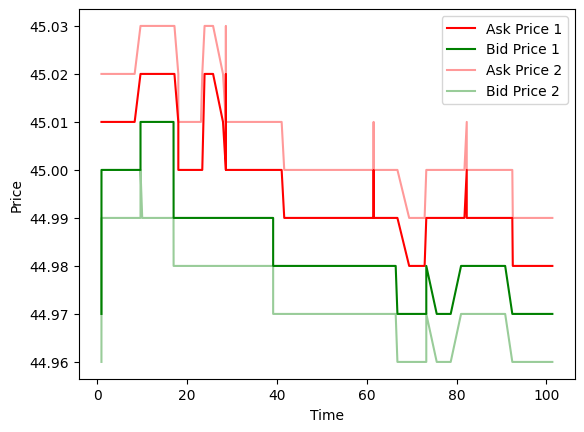

In [26]:
plt.plot(df['Time'] , df['Ask Price 1'], c = 'r' , label = 'Ask Price 1')
plt.plot(df['Time'] , df['Bid Price 1'], c = 'g', label = 'Bid Price 1')
plt.plot(df['Time'] , df['Ask Price 2'], c = 'r', alpha = 0.4, label = 'Ask Price 2')
plt.plot(df['Time'] , df['Bid Price 2'], c = 'g', alpha = 0.4, label = 'Bid Price 2')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Fit Fake Data

## Bin to custom bins

In [29]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
ric = "fake"
for d in range(N):
    l =  dataLoader.Loader(ric, d, d, dataPath = "tmp//")
    df = pd.read_csv(l.dataPath+"fake_"+str(d)+"_12D.csv")
    data = {str(d) : list(df.groupby('event')['Time'].apply(np.array)[cols].values)}
    cls = ConditionalLeastSquaresLogLin.ConditionalLeastSquaresLogLin(data, loader = l) 
    cls.runTransformDate()

0
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning


## Hawkes Graph

In [34]:
!pip install numba
!git clone https://github.com/achab/nphc.git nphc2
# in line 1 of nphc2/nphc/cumulants.py, remove the autojit import and line 235 remove decorator

Cloning into 'nphc2'...


In [6]:
!pip install --upgrade pip
!pip uninstall tensorflow
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------- ---------------------- 0.8/1.8 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 5.3 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\konar\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [8]:
import sys
import os
sys.path.append(os.getcwd()+"\\nphc2")
import matplotlib.pyplot as plt
from nphc.main import NPHC
import pandas as pd
import datetime as dt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
big_data = []
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]
for d in range(10): #pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
    
    df = pd.read_csv("./simulated_data/fake_"+str(d)+"_12D.csv")
    
    timestamps = list(df.groupby('event')['Time'].apply(np.array)[cols].values)
    big_data.append(timestamps)

In [ ]:
nphc = NPHC()
nphc.fit(big_data,half_width=1.,filtr="rectangular",method="parallel_by_day")
cumulants_list = [nphc.L, nphc.C, nphc.K_c]
from nphc.main import starting_point
start_point = starting_point(cumulants_list, random=True)
R_pred = nphc.solve(training_epochs=50000,display_step=500,learning_rate=1e-2,optimizer='adam')
d = len(nphc.L[0])
from scipy.linalg import inv
G_pred = np.eye(d) - inv(R_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
dimensions = cols 
sns_plot = sns.heatmap(G_pred.T,cmap="RdBu_r",xticklabels=dimensions,yticklabels=dimensions)

In [ ]:
boundsDict = {}
for i in range(12):
    for j in range(12):
        boundsDict[cols[i]+"->"+cols[j]] = np.sign(G_pred[i][j])
import pickle
with open(os.getcwd()+"/simulated_data/fake_2019-01-02_2019-03-31_graphDict", "wb") as f:
    pickle.dump(boundsDict, f)

## 12D Hawkes Non-Parametric Fit:

In [ ]:
ric = "fake"
dictIp = {}
d = 0
l =  dataLoader.Loader(ric, d, d, dataPath = "./simulated_data/")
for d in range(10):
    dictIp[str(d)] = []
cls = fit.ConditionalLeastSquaresLogLin(dictIp, loader = l, solver="osqp", path_dictTOD = "./fakeData_Params_sod_eod_dictTOD_constt")
thetas = cls.fitConditionalInSpread(spreadBeta = 1., avgSpread = 1.)
with open(l.dataPath + ric + "_Params_2019-01-02_2019-03-31_CLSLogLin_19" , "wb") as f:
    pickle.dump(thetas, f)

## Infer power law params:

In [ ]:
a, b = inference.run(dt.date(2019,1,2), dt.date(2019,3,31), ric = "fake" , avgSpread = 0.01, spreadBeta=1. , suffix = "_CLSLogLin_19")

# Simulate LOB from Fitted Fake Params

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(1):
    T, lob, lobL3=simulate.simulate(100, "fake_ParamsInferredWCutoff_2019-01-02_2019-01-31_CLSLogLin_19", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = 0.01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_CLSLogLinFit_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)